In [1]:
import sys
import json 
import cmath
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors

from numpy import sin, log, pi, angle, sqrt
import numpy as np
import mpmath as mp
from scipy.special import sph_harm, lpmv
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter
from matplotlib.ticker import LogLocator
import h5py
from math import floor, atan2, acos
sys.path.append('/mpdata/becker/yoge8051/Research/TDSE/General_Functions/')
import Module as Mod


In [2]:
def closest(lst, k): 
    r = lst[min(range(len(lst)), key = lambda i: abs(float(lst[i])-k))] 
    return r

def Wave_Function_Value(input_par, psi, grid, r, theta, phi, m):
    r = closest(grid, r)
    grid_idx = np.where(grid == r)[0][0]

    l_max_bs = input_par["l_max_bs_for_double_center"]
    return_val = 0.0j

    for l in range(m, l_max_bs):
        psi_idx = grid.size*l + grid_idx  
        return_val += 1/r*psi[psi_idx]*sph_harm(m, l, phi, theta)
     
    return return_val

def Target_File_Reader_WO_Parity(input_par):
    file = h5py.File(file_location + input_par["Target_File"], 'r')
    energy = {}
    wave_function = {}
    for m in range(input_par["m_max_bs_for_double_center"] + 1):
        n_quantum_number = 1
        for i in range(input_par["n_max"]):
            
            energy_temp = file["Energy_" + str(abs(m)) + "_" + str(i)]
            energy_temp = np.array(energy_temp[:,0] + 1.0j*energy_temp[:,1])
            wave_function_temp = file["Psi_" + str(abs(m)) + "_" + str(i)]
            wave_function_temp = np.array(wave_function_temp[:,0] + 1.0j*wave_function_temp[:,1])
            
            energy[(n_quantum_number, m)] = energy_temp
            wave_function[(n_quantum_number, m)] = wave_function_temp
            n_quantum_number += 1
    
    return energy, wave_function 

def PAD_Momentum_Two(input_par, psi, grid, m, axis_min, axis_max, resolution):

    x_axis = np.arange(axis_min , axis_max+resolution, resolution)
    z_axis = np.arange(axis_min , axis_max+resolution, resolution)

    y = 0
    pad_mag = np.zeros((z_axis.size,x_axis.size))
    pad_phase = np.zeros((z_axis.size,x_axis.size))
  
    z_print = z_axis[0:-1:int(len(z_axis)/5)]
    
    for i, z in enumerate(z_axis):

        if z in z_print:
            print(round(z,3))


        for j, x in enumerate(x_axis):
            pad_value_temp = 0.0j

            r = np.sqrt(x*x + y*y + z*z)
            if r == 0:
                r = 0.01

            phi = atan2(y, x)
            if phi < 0:
                phi = 2*pi + phi

            theta = np.arccos(z/r)
            
            val = Wave_Function_Value(input_par, psi, grid, r, theta, phi, m)

            pad_mag[j, i] = np.power(np.abs(val),2)
            pad_phase[j, i] = cmath.phase(val)


    pad_mag /= pad_mag.max()

    return pad_mag, pad_phase



In [3]:
file_location = "/mpdata/becker/yoge8051/Research/Data/Diatomic/Oxygen/"
input_par = Mod.Input_File_Reader(file_location + "input.json")
grid = Mod.Grid(input_par["grid_spacing"], input_par["grid_size"])
grid= grid.grid
energy, bound_states = Target_File_Reader_WO_Parity(input_par)

[-7.93638156+7.80139352e-15j]
-15.5
-9.5
-3.5
2.5
8.5
14.5
[-7.4556165+3.69274254e-14j]
-15.5
-9.5
-3.5
2.5
8.5
14.5


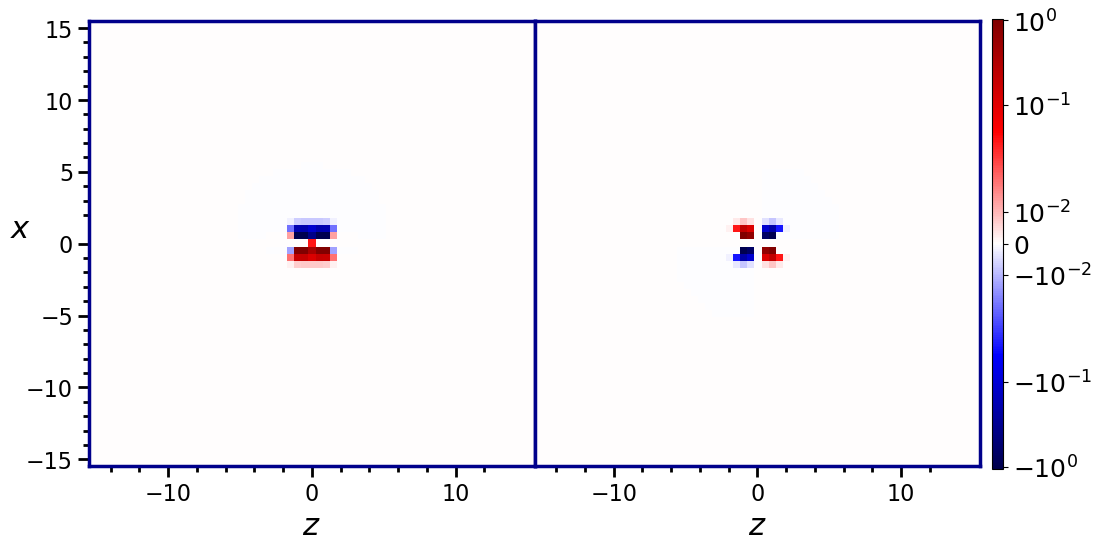

<Figure size 640x480 with 0 Axes>

In [8]:

axis_min = -5.5
axis_max = 5.5
resolution = 0.1

nrow = 1; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(11.5, 6), sharey=True)


for axis in ['top', 'bottom', 'left', 'right']:

    axs[0].spines[axis].set_linewidth(2.5)  # change width
    axs[0].spines[axis].set_color('darkblue')    # change color

    axs[1].spines[axis].set_linewidth(2.5)  # change width
    axs[1].spines[axis].set_color('darkblue')    # change color


axs[0].set_xlabel(r'$z$', fontsize=22)
axs[0].set_ylabel(r'$x$',rotation=0, fontsize=22)

axs[1].set_xlabel(r'$z$', fontsize=22)
# axs[1].set_ylabel(r'$x$',rotation=0, fontsize=22)

axs[0].tick_params(axis='both', which='major', labelsize=16, length=8, width=2)
axs[0].tick_params(axis='both', which='minor', labelsize=16, length=4, width=2)

axs[1].tick_params(axis='x', which='major', labelsize=16, length=8, width=2)
axs[1].tick_params(axis='x', which='minor', labelsize=16, length=4, width=2)

axs[1].tick_params(axis='y', which='both', length=0, width=0)

m, n = 0, 1
psi = bound_states[(n, m)]
print(energy[(n, m)])

pad_mag, pad_phase = PAD_Momentum_Two(input_par, psi, grid, m, axis_min, axis_max, resolution)
pad_phase = np.sign(pad_phase)*(-1)
pad = pad_mag*pad_phase


pos = axs[0].imshow(pad, cmap='seismic', extent=[axis_min, axis_max, axis_min, axis_max],  \
    norm=colors.SymLogNorm(linthresh=0.03, linscale=1., vmin=-1.05, vmax=1.05),)

m, n = 0, 2
psi = bound_states[(n, m)]
print(energy[(n, m)])

pad_mag, pad_phase = PAD_Momentum_Two(input_par, psi, grid, m, axis_min, axis_max, resolution)
pad_phase = np.sign(pad_phase)*(-1)
pad = pad_mag*pad_phase


pos = axs[1].imshow(pad, cmap='seismic', extent=[axis_min, axis_max, axis_min, axis_max],  \
    norm=colors.SymLogNorm(linthresh=0.03, linscale=1., vmin=-1.05, vmax=1.05),)




fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.12, 0.01, 0.75])
fig.colorbar(pos, cax=cbar_ax)

cbar_ax.tick_params(labelsize=18) 


axs[0].minorticks_on()
axs[1].minorticks_on()



yticks = axs[0].yaxis.get_minor_ticks()
yticks[12].set_visible(False)

xticks = axs[1].xaxis.get_minor_ticks()
xticks[-1].set_visible(False)

xticks = axs[0].xaxis.get_minor_ticks()
xticks[-1].set_visible(False)



plt.subplots_adjust(wspace=0, hspace=0)

# fig.tight_layout()

# plt.savefig("Plots/Hydrogen-Molecule-Orbitals-M-0.png")
plt.show()
plt.clf()



In [10]:

axis_min = -5.5
axis_max = 5.5
resolution = 0.05

nrow = 1; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(11.5, 6), sharey=True)


for axis in ['top', 'bottom', 'left', 'right']:

    axs[0].spines[axis].set_linewidth(2.5)  # change width
    axs[0].spines[axis].set_color('darkblue')    # change color

    axs[1].spines[axis].set_linewidth(2.5)  # change width
    axs[1].spines[axis].set_color('darkblue')    # change color


axs[0].set_xlabel(r'$z$', fontsize=22)
axs[0].set_ylabel(r'$x$',rotation=0, fontsize=22)

axs[1].set_xlabel(r'$z$', fontsize=22)
# axs[1].set_ylabel(r'$x$',rotation=0, fontsize=22)

axs[0].tick_params(axis='both', which='major', labelsize=16, length=8, width=2)
axs[0].tick_params(axis='both', which='minor', labelsize=16, length=4, width=2)

axs[1].tick_params(axis='x', which='major', labelsize=16, length=8, width=2)
axs[1].tick_params(axis='x', which='minor', labelsize=16, length=4, width=2)

axs[1].tick_params(axis='y', which='both', length=0, width=0)

m, n = 1, 5
psi = bound_states[(n, m)]
print(energy[(n, m)])

pad_mag, pad_phase = PAD_Momentum_Two(input_par, psi, grid, m, axis_min, axis_max, resolution)
pad_phase = np.sign(pad_phase)
pad = pad_mag*pad_phase


pos = axs[0].imshow(pad, cmap='seismic', extent=[axis_min, axis_max, axis_min, axis_max],  \
    norm=colors.SymLogNorm(linthresh=0.03, linscale=1., vmin=-1.05, vmax=1.05),)

m, n = 1, 6
psi = bound_states[(n, m)]
print(energy[(n, m)])

pad_mag, pad_phase = PAD_Momentum_Two(input_par, psi, grid, m, axis_min, axis_max, resolution)
pad_phase = np.sign(pad_phase)
pad = pad_mag*pad_phase


pos = axs[1].imshow(pad, cmap='seismic', extent=[axis_min, axis_max, axis_min, axis_max],  \
    norm=colors.SymLogNorm(linthresh=0.03, linscale=1., vmin=-1.05, vmax=1.05),)






# cb = plt.colorbar(pos, ax=axs[0])
# cb.set_label(label=r'$|\Psi|^2$', size=20,weight='bold', rotation="0",  y=0.56, x=0.94)


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.12, 0.01, 0.75])
fig.colorbar(pos, cax=cbar_ax)

cbar_ax.tick_params(labelsize=18) 
# cb = plt.colorbar(pos, ax=axs[1])
# cb.set_label(label=r'$|\Psi|^2$', size=20,weight='bold', rotation="0",  y=0.56, x=0.94)

# pos.axs[0].tick_params(axis='both',which='both',direction='out', width=2, length=4)

axs[0].minorticks_on()
axs[1].minorticks_on()



yticks = axs[0].yaxis.get_minor_ticks()
# yticks[12].set_visible(False)

xticks = axs[1].xaxis.get_minor_ticks()
# xticks[-1].set_visible(False)

xticks = axs[0].xaxis.get_minor_ticks()
# xticks[-1].set_visible(False)

# fig.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0)

# plt.savefig("Plots/Orbitals-M-1.png")

plt.show()
plt.clf()



[-6.74313425-2.45230588e-14j]
-5.5
-3.3
-1.1
1.1
3.3
[-6.7093047+3.72040616e-14j]
-5.5
-3.3
-1.1
